In [1]:
using AutomotiveDrivingModels
using AutoViz
using Interact
using Reactive

push!(LOAD_PATH, "../neural_network")
include("../neural_networks/neural_network.jl");

  likely near /Users/wulfebw/.julia/v0.5/Reel/src/Reel.jl:132
  likely near /Users/wulfebw/.julia/v0.5/Reel/src/Reel.jl:132


In [2]:
weights_filepath = "../../data/networks/test.weights"
network = load_network(weights_filepath);

In [3]:
const SAMPLING_FREQUENCY = 1. # hz
const SAMPLING_SECONDS = 3 # sec
const INIT_COLLISION_DIST = 3. # m

# roadway constants
const NUM_LANES = 1
const ROADWAY_LENGTH = 15. # m

# vehicle state constants
const EGO_SPEED = 2. # m/s
const OTHER_SPEED = 1. # m/s

# vehicle constants
const VEH_LENGTH = 1.
const VEH_WIDTH = 1.
const GREEN = HSV(90, 0.85, 0.85)
const RED = HSV(0, 0.85, 0.85)
const BLUE = HSV(180, 0.85, 0.85)

# network constants
const MEAN = 0.9772956
const STD_DEV =  0.7125508

# function for building a driver
function build_static_driver(context::IntegratedContinuous)
    # static longitudinal driver with accel 0
    mlon = StaticLongitudinalDriver(0.)

    # build driver model
    model = Tim2DDriver(context, mlon=mlon)

    return model
end;

distance to front vehicle: 2.297287984535462
probability of collision at next time step: 3.58282775542244e-26


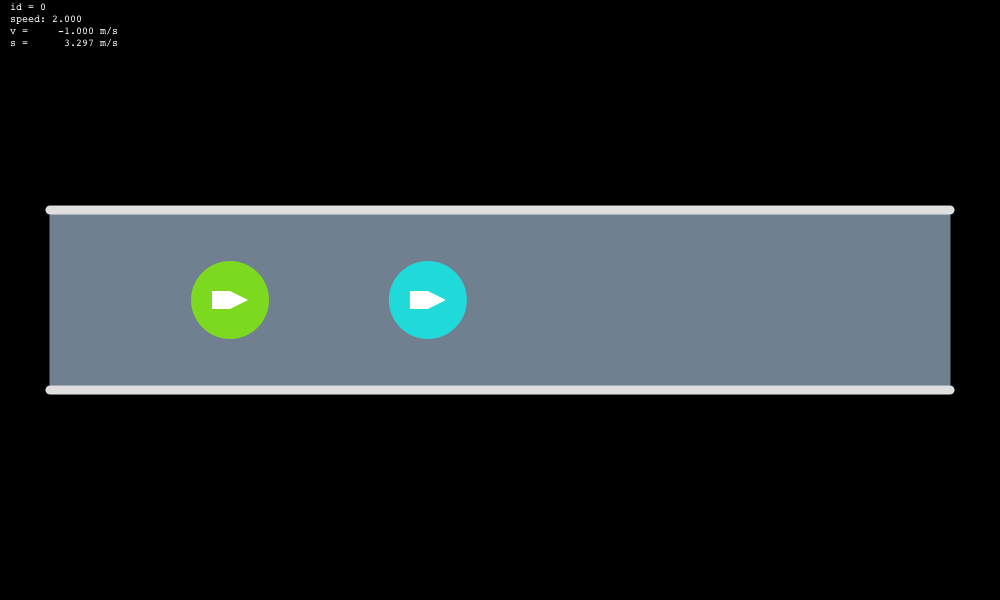

In [4]:
# random number generator
rng = MersenneTwister(1)
framerate = 1.

# roadway
roadway = gen_straight_roadway(NUM_LANES, ROADWAY_LENGTH)
    
# vehicles
ego_road_idx = RoadIndex(proj(VecSE2(0.0,0.0,0.0), roadway))
other_road_idx = RoadIndex(proj(VecSE2(0.0,0.0,0.0), roadway))
num_veh = 2

# scene
scene = Scene(num_veh)
rec = SceneRecord(10, SAMPLING_FREQUENCY, num_veh)
models = Dict{Int, DriverModel}()
carcolors = Dict{Int,Colorant}()

function reset!(scene)
    empty!(scene)
    context = IntegratedContinuous(1 / SAMPLING_FREQUENCY, 1)
    
    # vehicle states
    ego_vehstate = VehicleState(Frenet(ego_road_idx, roadway), roadway, EGO_SPEED)
    other_vehstate = VehicleState(Frenet(other_road_idx, roadway), roadway, OTHER_SPEED)

    # ego position
    ego_x = 1.
    ego_vehstate = move_along(ego_vehstate, roadway, ego_x)

    # place other vehicle in front of ego vehicle
    rand_displacement = max(min(randn(rng), 1.5), -1.5)
    other_x = rand_displacement + INIT_COLLISION_DIST + ego_x + VEH_LENGTH
    other_vehstate = move_along(other_vehstate, roadway, other_x)

    # add vehicles to scene
    ego_vehdef = VehicleDef(0, AgentClass.CAR, VEH_LENGTH, VEH_WIDTH)
    push!(scene, Vehicle(ego_vehstate, ego_vehdef))
    other_vehdef = VehicleDef(1, AgentClass.CAR, VEH_LENGTH, VEH_WIDTH)
    push!(scene, Vehicle(other_vehstate, other_vehdef))

    # build driver models
    models[0] = build_static_driver(context)
    models[1] = build_static_driver(context)
end

reset!(scene)
actions = get_actions!(Array(DriveAction, length(scene)), scene, roadway, models)
function drawsim(t, dt=NaN)
    # if past a certain point restart
    if scene.vehicles[1].state.posG.x > 10
        reset!(scene)
        empty!(rec)
    end

    # propagate forward in time
    get_actions!(actions, scene, roadway, models)
    tick!(scene, roadway, actions, models)
    
    # update the scene record
    update!(rec, scene)
    
    # extract features and normalize
    dist = convert(Float64, get(DIST_FRONT, rec, roadway, 1))
    println("distance to front vehicle: $(dist)")
    dist = (dist - MEAN) / STD_DEV
    

    # predict probability of collision with network
    prob = fprop_network(network, [dist])[1]
    println("probability of collision at next time step: $(prob)")
    
    # set car colors
    carcolors[0] = convert(RGB, HSV(90 * (1 - prob), 0.85, 0.85))
#     carcolors[0] = convert(RGB, GREEN)
    carcolors[1] = convert(RGB, BLUE)
    
    # render
    render(scene, roadway, [CarFollowingStatsOverlay(0)], cam=FitToContentCamera(), car_colors=carcolors)
end

drawsim(1)

distance to front vehicle: 1.297287984535462
probability of collision at next time step: 2.1974672150539494e-8


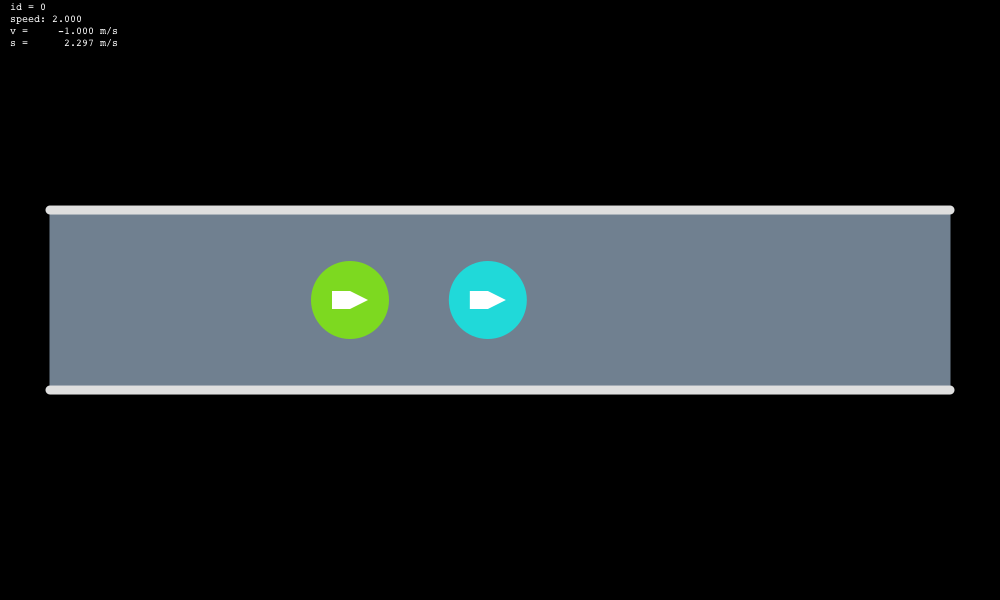

In [5]:
ticks = fps(framerate)
timestamps = map(_ -> time(), ticks)
map(drawsim, timestamps)

In [ ]:
# using Reel
# film = roll(drawsim, fps=framerate, duration=60)
# write("/Users/wulfebw/Desktop/nnet_auto.gif", film)